Split the protocol into training, validation and testing set and then augment and train.

In [1]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, dw_gen, perform_eval
from modelval.ArbDataGen import arb_w_gen
from modelval.spk_visu import spk_see, raster
from modelval import gp_regressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60


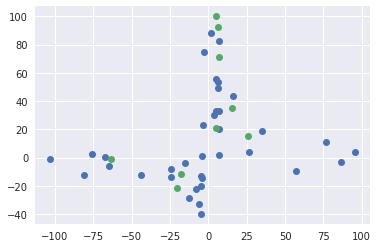

In [25]:
# Generate data for STDP
data1 = data[data['ptl_idx']==1]

# Split into training and testing set (80%, 20%)
# Create train/vali and test data frame
np.random.seed(0)

x_train, x_test, y_train, y_test = train_test_split(data1['dt1'], data1['dw_mean'],test_size=0.2, random_state=0)
plt.plot(x_train, y_train,'o')
plt.plot(x_test, y_test,'o')

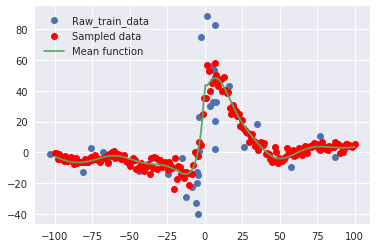

In [32]:
# Fit the training data with Gaussian process
x = x_train.reshape(-1,1)
y = y_train.reshape(-1,1)
x_aug = np.linspace(-100,100,200).reshape(-1,1)

# Use Gaussin regressor that have been validated using hyperparameter
gp_rg = gp_regressor.GP_regressor(x, y, x_aug,sigma_kernel=1.68, scale=20.0, bias=4.5, sigma_obs=5.0, noise_const=81.1, if_stat_kernel=False, if_stat_noise=False)
f, v_f, lp = gp_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)
plt.plot(x, y,'o', label='Raw_train_data')
#plt.fill_between(np.squeeze(x_aug), np.squeeze(f-1.96*std), np.squeeze(f+1.96*std), alpha=1, color='deeppink', label="95% confidence interval")

# Sample from the gp regression
noise_sigma = 5 * np.exp(-1 * np.abs(x_aug)/81.1)

# Sample from the modified distribtion

# cov_gen = v_f + np.dot(noise_sigma.T, np.eye(noise_sigma.shape[0]))
# f_samp = gp_rg.sample(10, cov=cov_gen)

scale = np.zeros(f.shape)
noise = np.zeros(f.shape)
f_samp = np.zeros(f.shape)

for i in range(len(f)):
    np.random.seed(i)
    scale[i] = 5 * np.exp(-1 * np.abs(x_aug[i])/81.1)
    noise[i] = np.random.normal(loc=0, scale=scale[i], size=1)
    f_samp[i] = f[i] + noise[i] 
    
plt.plot(x_aug, f_samp, 'ro', label='Sampled data')
plt.plot(x_aug, f, label='Mean function')

plt.legend(loc='upper left')

In [33]:
# Split into training and validation dataset
X_train, X_vali, y_train, y_vali = train_test_split(x_aug, f, test_size=0.2)

In [34]:
data_gen_train = dw_gen.STDP_dw_gen_gp(X_train)
data_gen_vali = dw_gen.STDP_dw_gen_gp(X_vali)

In [35]:
len(data_gen_train)

160

In [36]:
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

In [37]:
# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms

ker_test = KernelGen(len_kernel=51)
ker_test.trip_model_ker(para, data_name='Hippocampus')

In [38]:
# Generat the spike trains and targets for STDP
ptl_list = [1]
spk_len = int(data1['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 1
aug_times = [10]
spk_pairs_train, targets_train = arb_w_gen(df=data_gen_train, ptl_list=ptl_list, targets=y_train, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='pair', aug_times=aug_times)
spk_pairs_vali, targets_vali = arb_w_gen(df=data_gen_vali, ptl_list=ptl_list, targets=y_vali, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='pair', aug_times=aug_times)

In [39]:
spk_pairs_train.shape, targets_train.shape, spk_pairs_vali.shape, targets_vali.shape

((1600, 30000, 2), (1600, 1), (400, 30000, 2), (400, 1))

In [40]:
# Create the network
ground_truth_init = 0
reg_scale=(1, 1)
toy_data_net = network.PairNet(kernel=ker_test, ground_truth_init=ground_truth_init, reg_scale=reg_scale, n_input=spk_pairs_train.shape[1])

In [41]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/Pair_ptl1_real_aug_gp'
# optimizer_op = tf.train.GradientDescentOptimizer
toy_net_trainer = trainer.Trainer(toy_data_net.loss, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [42]:
train_data = dataset.Dataset(spk_pairs_train, targets_train)
vali_data = dataset.Dataset(spk_pairs_vali, targets_vali)

[ 0.35749316  0.42830181] 0.0


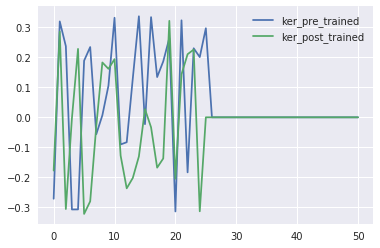

In [43]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(w_pre,  label='ker_pre_trained')
plt.plot(w_post,  label='ker_post_trained')
plt.legend()
print(fc_w[:2], bias)

In [44]:
# # Learn the kernel from random initialization
# learning_rate = 0.001
# iterations = 5
# min_error = -1
# for i in range(iterations):
#     toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
#     learning_rate = learning_rate/3

[array([ 1.01010191,  0.782368  , -0.06036615], dtype=float32), 0.38978621]


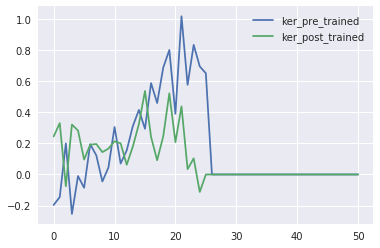

In [45]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(w_pre, label='ker_pre_trained')
plt.plot(w_post, label='ker_post_trained')
plt.legend()
print([fc_w, bias])

In [46]:
ker_test.kernel_pre = w_pre
ker_test.kernel_post = w_post
# ker_test.kernel_post_post= w_post_post
ker_test.kernel_scale = fc_w
ker_test.bias = bias

In [47]:
# Generate training predictions
spk_len = int(data1['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, predictions = arb_w_gen(spk_pairs=spk_pairs_train, spk_len=spk_len, kernel=ker_test, net_type='pair')

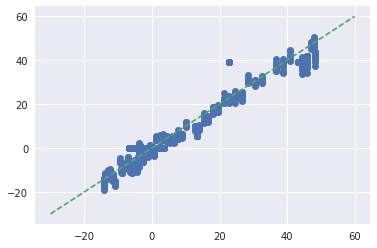

In [48]:
plt.plot(targets_train, predictions, 'o')
plt.plot(np.linspace(-30,60,90),np.linspace(-30,60,90),'--')

In [49]:
# Generate training predictions
spk_len = int(data1['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, predictions = arb_w_gen(spk_pairs=spk_pairs_vali, spk_len=spk_len, kernel=ker_test, net_type='pair')

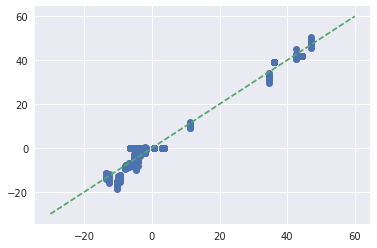

In [50]:
plt.plot(targets_vali, predictions, 'o')
plt.plot(np.linspace(-30,60,90),np.linspace(-30,60,90),'--')

Compare the target and prediction

In [51]:
data_gen_test = dw_gen.STDP_dw_gen(x_test.values)

In [52]:
# Generat the spike trains and targets for STDP
ptl_list = [1]
spk_len = int(data1['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 1
aug_times = [1]
spk_pairs_test, targets_test = arb_w_gen(df=data_gen_test, ptl_list=ptl_list, targets=y_test.values, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='pair', aug_times=aug_times)

In [53]:
spk_pairs, predictions = arb_w_gen(spk_pairs=spk_pairs_test, spk_len=spk_len, kernel=ker_test, net_type='pair')

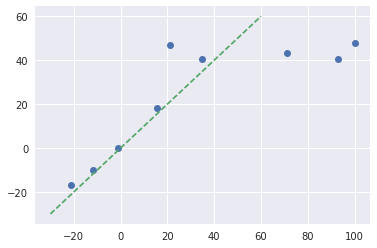

In [54]:
plt.plot(targets_test, predictions, 'o')
plt.plot(np.linspace(-30,60,90),np.linspace(-30,60,90),'--')